# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_taxi_train = pd.read_csv("train.csv")
display(df_taxi_train.sample(4))
display(df_taxi_train.info())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1067149,id2755258,1,2016-05-03 09:47:47,2016-05-03 09:54:23,1,-73.984398,40.737179,-73.982819,40.743832,N,396
248735,id2818086,2,2016-05-28 22:41:33,2016-05-28 22:47:34,5,-73.977760,40.729271,-73.984833,40.719578,N,361
1250682,id3727741,1,2016-05-06 11:49:41,2016-05-06 12:01:11,1,-74.000587,40.735809,-73.986694,40.740543,N,690
88912,id2846069,2,2016-05-03 17:09:18,2016-05-04 17:08:29,6,-73.962608,40.778702,-73.985268,40.768742,N,86351


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_taxi_train.drop('dropoff_datetime', axis=1, inplace=True)
df_taxi_train.loc[:, 'pickup_datetime'] = pd.to_datetime(df_taxi_train['pickup_datetime'], errors='raise', format='%Y-%m-%d %H:%M:%S')

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

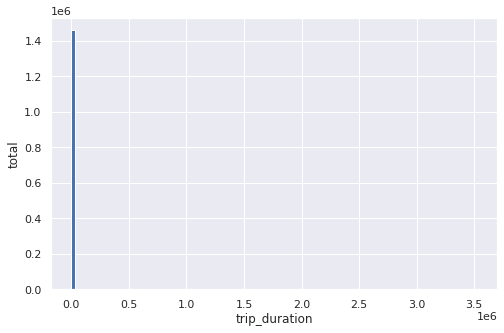

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・
df_taxi_train['trip_duration'].hist(bins=100, figsize=(8, 5))
plt.xlabel('trip_duration')
plt.ylabel('total')
plt.show();

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Обладает большой дисперсией

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**:
$\log{x}$ преобразует много-асимметричные значения строго неотрицательной целевой переменной, сжимая их к куда меньшим масштабам. 

Т.о. RMSLE в данном случае большой дисперсии целевой переменной (см.гистограмму) будет иметь куда более нормализованную ошибку чем RMSE, а модель не переобучится на данные выбросного характера с большими значениями целевой переменной 

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

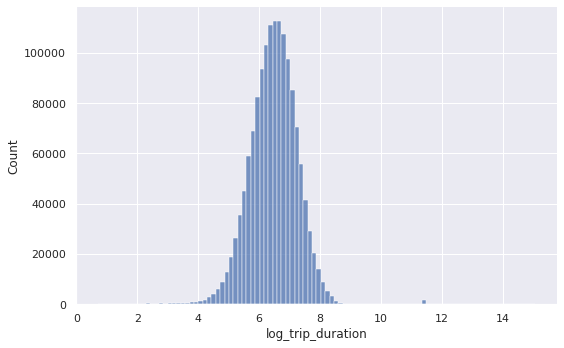

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_taxi_train = df_taxi_train.assign(
    log_trip_duration = np.log1p(df_taxi_train['trip_duration'])
)
#figsize(1.6*5, 5) as displot parameter
sns.displot(df_taxi_train['log_trip_duration'], bins=100, height=5, aspect=1.6);

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

$\hat{y}=w;$ __МНК:__ $Q = \sum_{i=1}^n(y - \hat{y}) ^ 2 \to min$

$Q'_w = 2\sum_{i=1}^n(y - w) = 0; \sum_{i=1}^ny - nw = 0; w = \frac{1}{n} {\sum_{i=1}^ny}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import mean_squared_error

w_0 = df_taxi_train['log_trip_duration'].mean()
print(
    "MSE = %.4f" % mean_squared_error(df_taxi_train['log_trip_duration'], w_0 * np.ones(df_taxi_train.shape[0]))
)

MSE = 0.6332


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

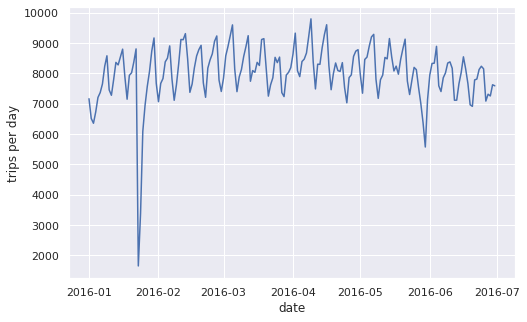

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(8, 5))
trips_by_days = df_taxi_train.groupby(by=df_taxi_train['pickup_datetime'].dt.floor(freq='D'))['id'].count()
plt.plot(trips_by_days.index, trips_by_days.values)
plt.xlabel('date')
plt.ylabel('trips per day')
plt.show();

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
#1.5-sigma rule to detect anomaly
mask_anomaly = trips_by_days < (trips_by_days.mean() - 1.5*trips_by_days.std())
trips_by_days[mask_anomaly]

pickup_datetime
2016-01-02    6512
2016-01-03    6353
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-05-29    6372
2016-05-30    5570
Name: id, dtype: int64

__Ответ__: 
 - в новогодние праздники было мало поездок (не является аномальным периодом)
 - в период конца января 2016-го года в Нью-Йорке случилась сильная метель, из-за которой [было ограничено движение](https://ria.ru/20160123/1364032228.html).

 - Празднование Дня Памяти.

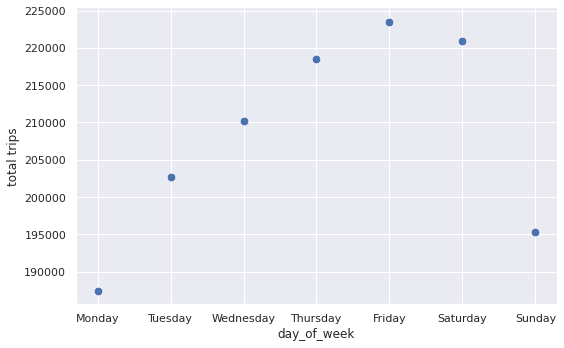

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

trips_by_hours = df_taxi_train.groupby(by=df_taxi_train['pickup_datetime'].dt.floor(freq='H'))['id'].count()
df_hours_days = pd.concat(
    [
     trips_by_hours,
     trips_by_hours.index.to_series().dt.weekday.rename('day_of_week'), #weekday
     trips_by_hours.index.to_series().dt.hour.rename('hour_of_day')
    ], axis=1 
)

days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_total_days = df_hours_days.groupby(by='day_of_week')['id'].sum()
df_total_days.index = df_total_days.index.map(days.get)
sns.relplot(
    data=df_total_days,
    height=5, aspect=1.6, s=75
)
plt.ylabel('total trips')
plt.show();

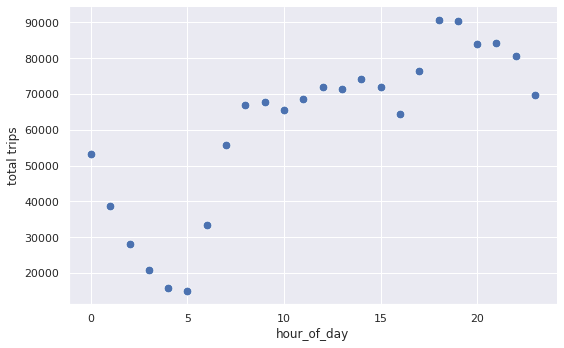

In [ ]:
sns.relplot(
    data=df_hours_days.groupby(by='hour_of_day')['id'].sum(),
    height=5, aspect=1.6, s=75
)
plt.ylabel('total trips')
plt.show();

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

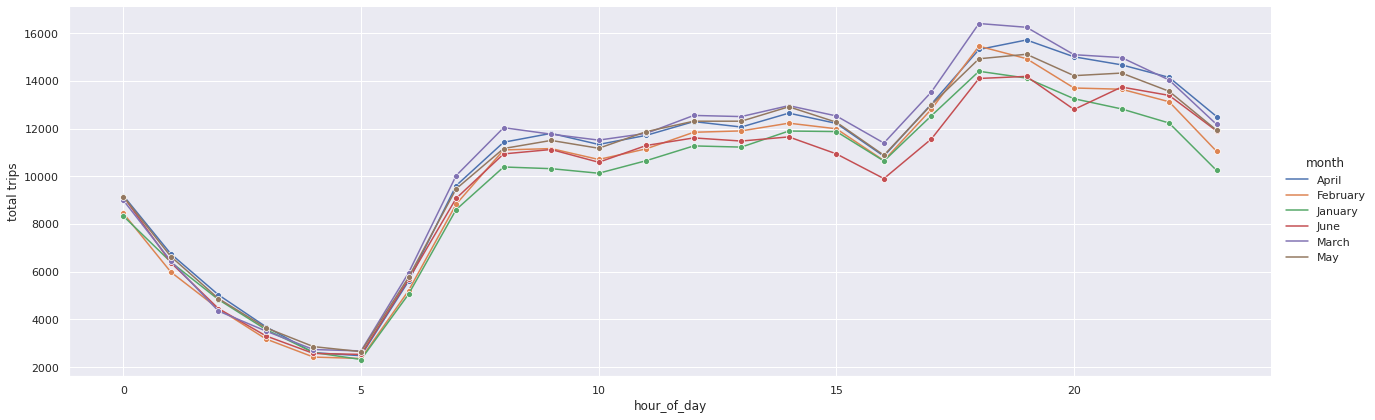

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

hours_by_month = df_hours_days.assign(
    month=df_hours_days.index.to_series().dt.month_name()
).groupby(by=['hour_of_day', 'month'])['id'].sum()

sns.relplot(
    x='hour_of_day',
    y=hours_by_month.values,
    hue='month',
    data=hours_by_month, kind='line',
    height=6, aspect=3, marker ='o'
)
plt.ylabel('total trips')
plt.show();

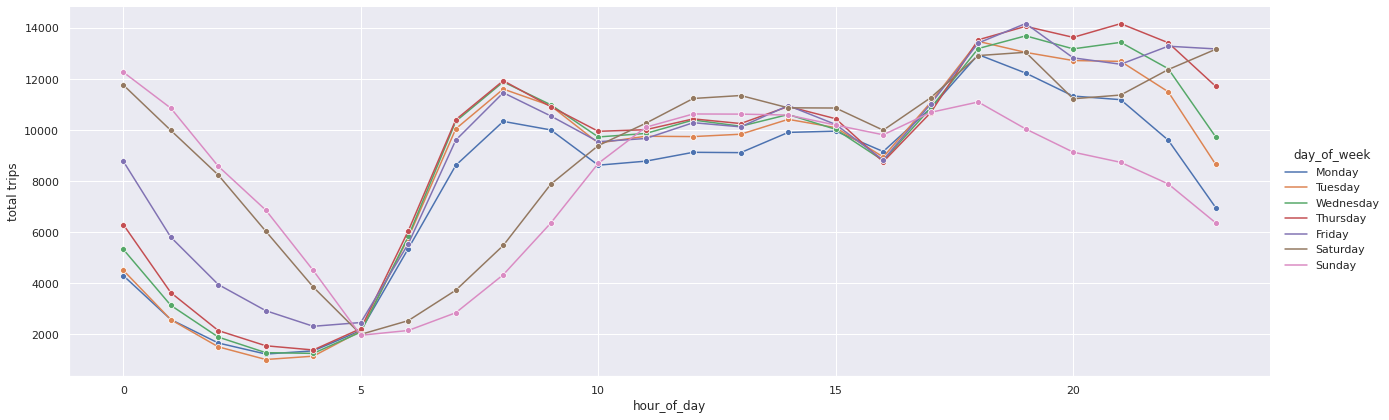

In [ ]:
hours_by_days = df_hours_days.groupby(by=['hour_of_day', 'day_of_week'])['id'].sum()
hours_by_days.index.set_levels(list(days.values()), level=1, inplace=True)
sns.relplot(
    x='hour_of_day',
    y=hours_by_days.values,
    hue='day_of_week',
    data=hours_by_days, kind='line',
    height=6, aspect=3, marker ='o'
)
plt.ylabel('total trips')
plt.show();

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**:
 - к концу рабочих дня/недели кол-во поездок увеличивается
 - в вечер субботы/пятницы загружен поездками, как и ночь субботы/воскресенья: вечерний досуг населения больших городов в конце недели
 - понедельник отличается куда меньшим кол-вом поездок от остальных рабочих дней: возможно из-за 4-х дневных рабочих недель
 - в январе мало используют такси: возможно из-за праздников

__Вывод__: дневное/годовое поведение кол-ва поездок скорее всего характеризуется достаточно деловой атмосферой города

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

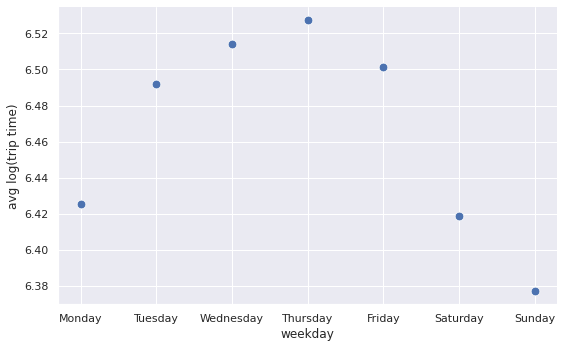

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(df_taxi_train, test_size=0.3, random_state=5)

Train_avg_weekdays=Train.groupby(by=Train['pickup_datetime'].dt.weekday)['log_trip_duration'].mean()
Train_avg_weekdays.index = Train_avg_weekdays.index.map(days.get)
sns.relplot(
    data=Train_avg_weekdays,
    height=5, aspect=1.6, s=75
)
plt.xlabel('weekday')
plt.ylabel('avg log(trip time)')
plt.show();

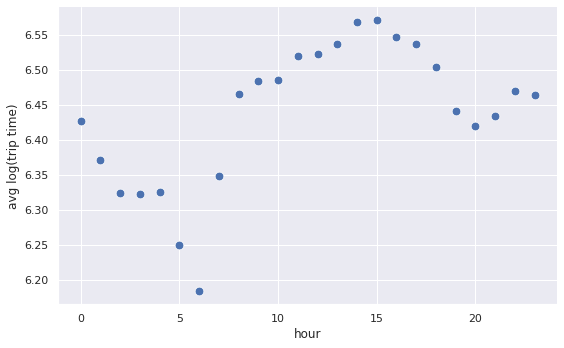

In [ ]:
sns.relplot(
    data=Train.groupby(by=Train['pickup_datetime'].dt.hour)['log_trip_duration'].mean(),
    height=5, aspect=1.6, s=75
)
plt.xlabel('hour')
plt.ylabel('avg log(trip time)')
plt.show();

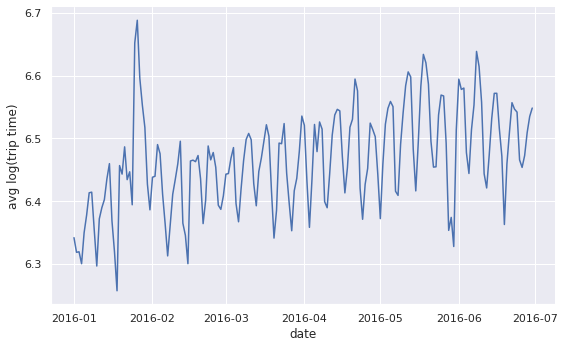

In [ ]:
sns.relplot(
    data=Train.groupby(by=Train['pickup_datetime'].dt.floor(freq='D'))['log_trip_duration'].mean(),
    kind='line',
    height=5, aspect=1.6
)
plt.xlabel('date')
plt.ylabel('avg log(trip time)')
plt.show();

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**:
 - Похожи, м.б. из-за деловой специфики города: от дома до места работы едут дальше(дольше), а до ближайшего места досуга/булочной ближе(меньше). Также стоит учитывать утренний час пик
 - В период аномальной метели те поездки, которые случились, были долгими скорее всего из-за условий на дорогах
 - В период майского Дня Памяти, вероятно, улицы были перекрыты, поэтому поездки были короткими
 - Наблюдается возрастающий тренд лог-ма времени поездки

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def add_datetime_features(data):
    anomaly_1st_mask = data['pickup_datetime'].between('2016-01-23', '2016-01-26')
    anomaly_2nd_mask = data['pickup_datetime'].between('2016-05-29', '2016-05-31')
    return data.assign(
        weekday = data['pickup_datetime'].dt.day_name(),
        month_year = data['pickup_datetime'].dt.month_name(),
        hour_day = data['pickup_datetime'].dt.hour,
        anomaly_period_1st = anomaly_1st_mask,
        anomaly_period_2nd = anomaly_2nd_mask,
        day_year = data['pickup_datetime'].dt.dayofyear
    )

Train, Test = add_datetime_features(Train), add_datetime_features(Test)
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437594 entries, 565322 to 1326501
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  437594 non-null  object        
 1   vendor_id           437594 non-null  int64         
 2   pickup_datetime     437594 non-null  datetime64[ns]
 3   passenger_count     437594 non-null  int64         
 4   pickup_longitude    437594 non-null  float64       
 5   pickup_latitude     437594 non-null  float64       
 6   dropoff_longitude   437594 non-null  float64       
 7   dropoff_latitude    437594 non-null  float64       
 8   store_and_fwd_flag  437594 non-null  object        
 9   trip_duration       437594 non-null  int64         
 10  log_trip_duration   437594 non-null  float64       
 11  weekday             437594 non-null  object        
 12  month_year          437594 non-null  object        
 13  hour_day            437

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

__Ответ__:
 - категориальные: День недели, Месяц, Час(зависимость _не монотонна_)
 - численные: День в году

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
Train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'weekday', 'month_year', 'hour_day',
       'anomaly_period_1st', 'anomaly_period_2nd', 'day_year'],
      dtype='object')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
# Sequentially apply a list of transforms to columns of an array or pandas DataFrame
from sklearn.pipeline import make_pipeline
# from sklearn.pipeline import Pipeline
# Sequentially apply a list of transforms and a final estimator. 
# Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. 
# The final estimator only needs to implement fit.

features = Train.columns[11:]
target = 'log_trip_duration'

numeric_cols = ['day_year']
categor_cols = ['weekday', 'month_year', 'hour_day']

preprocessor = ColumnTransformer(
    [
     ('numerical', StandardScaler(), numeric_cols),
     ('categorical', OneHotEncoder(handle_unknown="ignore"), categor_cols)
    ],
    remainder='passthrough'
)

work_pipe = make_pipeline(preprocessor, Ridge()) # default step-name duplicates the method so 'ridge': Ridge()
model = work_pipe.fit(Train[features], Train[target])

y_pred = model.predict(Test[features])

print("MSE = %.8f" % mean_squared_error(Test[target], y_pred))

MSE = 0.62165626


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df_taxi_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(df_taxi_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    d = np.sin((lat2 - lat1) * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((lng2 - lng1) * 0.5) ** 2
    res = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return res

Train = Train.assign(
    haversine = haversine_array(
        Train['pickup_latitude'].values, Train['pickup_longitude'].values,
        Train['dropoff_latitude'].values, Train['dropoff_longitude'].values,    
    )
)   

Test = Test.assign(
    haversine = haversine_array(
        Test['pickup_latitude'].values, Test['pickup_longitude'].values,
        Test['dropoff_latitude'].values, Test['dropoff_longitude'].values,    
    )
)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Train = Train.assign(log_haversine = np.log1p(Train['haversine'].values))
Test = Test.assign(log_haversine = np.log1p(Test['haversine'].values))

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Train.loc[:, ['haversine', 'log_haversine']].corrwith(Train[target])

haversine        0.575211
log_haversine    0.749820
dtype: float64

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

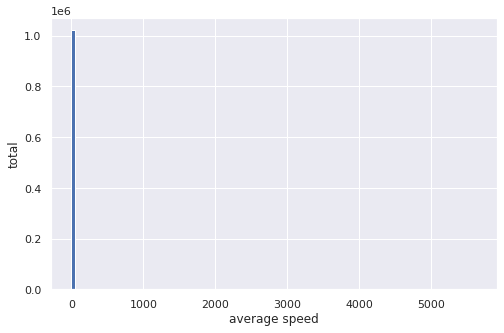

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
speed_avg = 3600 * Train['haversine'] / Train['trip_duration']
speed_avg.hist(bins=100, figsize=(8, 5))
plt.xlabel('average speed')
plt.ylabel('total')
plt.show();

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

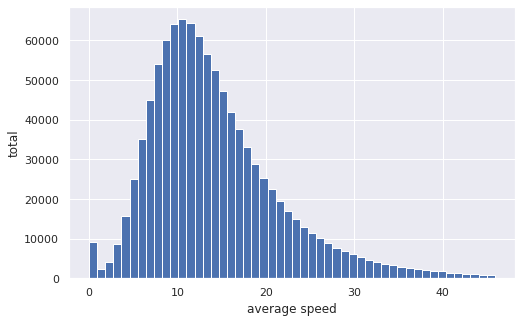

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
speed_avg[speed_avg < 4 * speed_avg.std()].hist(bins=50, figsize=(8, 5))
plt.xlabel('average speed')
plt.ylabel('total')
plt.show();

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

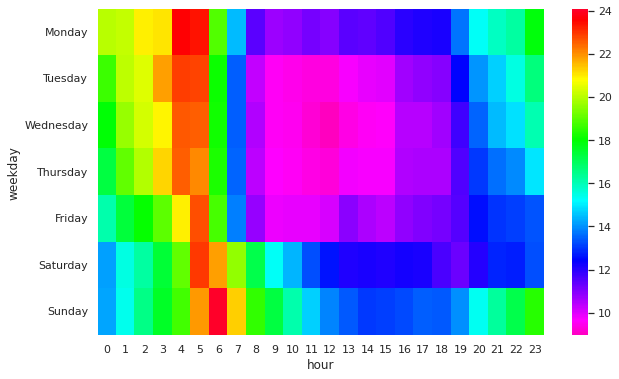

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

df_speed_med_dist = Train.assign(
    speed = speed_avg
).groupby(by=['weekday', 'hour_day'])['speed'].median().unstack(level='hour_day').reindex(days.values())
plt.figure(figsize=(10, 6))
sns.heatmap(df_speed_med_dist, cmap="gist_rainbow_r")
plt.xlabel("hour")
plt.show();

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

__Ответ__: Зависит от введенных временных признаков в предыдущей части - возникнет проблема мультиколлинеарности

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def in_limits_mask(col_cat, col_num, limits_dict):
    df_limits = col_cat.map(
        limits_dict, na_action='ignore'
    ).dropna()

    df_limits = pd.DataFrame(df_limits.tolist(), index=df_limits.index, columns=['low', 'up'])
    return col_num.ge(df_limits['low']) & col_num.le(df_limits['up'])

jams = {'Tuesday' : (9, 15), 'Wednesday' : (9, 15), 'Thursday' : (9, 15), 'Friday' : (9, 11)}
free_road = {
    'Monday' : (2, 5), 'Tuesday' : (3, 5), 'Wednesday' : (3, 5), 'Thursday' : (3, 5),
    'Friday' : (4, 5), 'Saturday' : (4, 5), 'Sunday' : (5, 7)
}

Train = Train.assign(
    is_jams_period = in_limits_mask(Train.weekday, Train.hour_day, jams),
    is_freeroad_period = in_limits_mask(Train.weekday, Train.hour_day, free_road)
)

Test = Test.assign(
    is_jams_period = in_limits_mask(Test.weekday, Test.hour_day, jams),
    is_freeroad_period = in_limits_mask(Test.weekday, Test.hour_day, free_road)
)

Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437594 entries, 565322 to 1326501
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  437594 non-null  object        
 1   vendor_id           437594 non-null  int64         
 2   pickup_datetime     437594 non-null  datetime64[ns]
 3   passenger_count     437594 non-null  int64         
 4   pickup_longitude    437594 non-null  float64       
 5   pickup_latitude     437594 non-null  float64       
 6   dropoff_longitude   437594 non-null  float64       
 7   dropoff_latitude    437594 non-null  float64       
 8   store_and_fwd_flag  437594 non-null  object        
 9   trip_duration       437594 non-null  int64         
 10  log_trip_duration   437594 non-null  float64       
 11  weekday             437594 non-null  object        
 12  month_year          437594 non-null  object        
 13  hour_day            437

**Задание 8 (0.25 балла)**. Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки


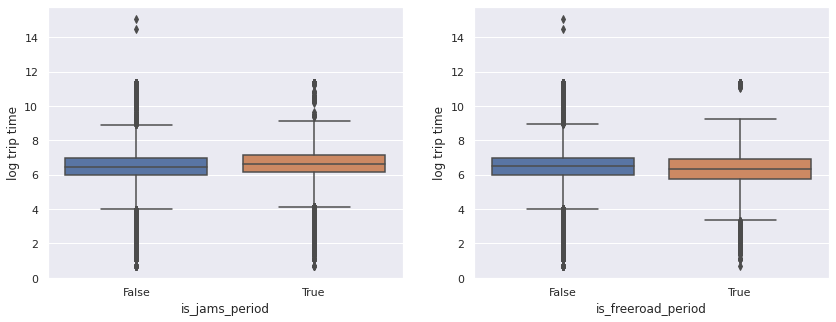

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
for i, col in enumerate(Train.columns[-2:]):
    sns.boxplot(x=col, y=target, data=Train, whis=2, ax=axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('log trip time')

plt.show();

# whis - coef of IQR (InterQuartileRange)
# IQR = quantile_0.75 - quantile_0.25
# outliners = (quantile_0.25 - whis*IQR, quantile_0.75 + whis*IQR)
# in Gauss distr (where (quantile_0.25, quantile_0.75)  = +-0.675σ )
# outliners(default whis) = (+-2.7σ)
# outliners(whis=2) = (+-3.375σ)
# outliners 3σ-rule ~ outliners(whis=1.7)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: судя по графикам, нет: малая разница в распределениях (середина `boxplot` соотв-ет медиане, границы коробок - 1-й и 2-й квартили)

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lat_limits=(40.70076, 40.802885), 
                 long_limits=(-74.02005, -73.930360), nlat=5, nlong=4):
        super().__init__() # get ['BaseEstimator', 'TransformerMixin'] attributes
        self.lat_limits, self.long_limits = lat_limits, long_limits
        self.nlat, self.nlong = nlat, nlong

    def transform(self, X):
        coords = X.values.T
        latitude_grid = np.linspace(self.lat_limits[0], self.lat_limits[1], self.nlat)
        longtitude_grid = np.linspace(self.long_limits[0], self.long_limits[1], self.nlong)
        axs_ids = np.array(
            list(
                map(
                    self.__column_binning, 
                    coords, 
                    (longtitude_grid, latitude_grid) * 2
        )))

        # axs_ids = [[long_ids], [lat_ids], [long_ids], [lat_ids] ..]
        # area_grid = <vectoris-n of mtx indicies> = i*n + j = lat_ids * dim(long_ids) + long_ids
        # cause np.digitize for in_grid return range(1,len-1) & dim(long_ids) defines gridpoints (not grid-areas) => 
        # areas_indecies = (lat_ids-1) * (dim(long_ids)-1) + (long_ids - 1)

        area_ids = np.where(
            (axs_ids[::2] < 0) | (axs_ids[1::2] < 0),
            -1, 
            (axs_ids[1::2] - 1)*(self.nlong - 1) + (axs_ids[::2] - 1)
        )
        return area_ids.T

    def fit(self, X, y=None):
        # The fit method is where “learning” takes place. Here we perform the operation based upon the training data that yields the model parameters.
        # In the transform method, we apply the parameters learned in fit to unseen data. 
        # Bear in mind that the preprocessing is going to make part of the whole model, so during training, fit, and transform are apply to the same dataset. 
        # But later, when you use the trained model, you only apply the transform method with the parameter learned with fit based on the training dataset but on unseen data.
        # It is key that the learned parameters, and hence the transformer operation, are the same regardless of the data to be applied to.

        # so that nothing to learn here from training data, no unique stat for both train/test e.t.c for our transformer
        return self

    def __column_binning(self, arr, bins):
        bin_ids = np.digitize(arr, bins)
        return np.where((bin_ids == len(bins)) | (bin_ids == 0), -1, bin_ids)

In [ ]:
map_gr_tf = MapGridTransformer(nlat=5, nlong=5)
Train = Train.assign(
     **dict(
          zip(('pickup_cell', 'dropoff_cell'), map_gr_tf.fit_transform(Train.iloc[:, 4:8]).T)
     )
)

Test = Test.assign(
     **dict(
          zip(('pickup_cell', 'dropoff_cell'), map_gr_tf.fit_transform(Test.iloc[:, 4:8]).T)
     )
)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# code maptransformer in pipeline, but data loses areas as constant features 
# features = Train.columns[4:8].append(Train.columns[11:]).drop('haversine')
features = Train.columns[11:].drop('haversine')
target = 'log_trip_duration'

numeric_cols = ['log_haversine', 'day_year']
categor_cols = ['weekday', 'month_year', 'hour_day', 'pickup_cell', 'dropoff_cell']
# coord_cols = Train[features].columns[0:4]
# numeric_cols = Train[features].select_dtypes(include='number').columns.drop(coord_cols)

preprocessor = ColumnTransformer(
    [
    #  ('zone_division', MapGridTransformer(nlat=5, nlong=5), coord_cols),
     ('numerical', StandardScaler(), numeric_cols),
     ('categorical', OneHotEncoder(handle_unknown="ignore"), categor_cols)
    ],
    remainder='passthrough'
)

work_pipe = make_pipeline(preprocessor, Ridge())
model = work_pipe.fit(Train[features], Train[target])

y_pred = model.predict(Test[features])

print("MSE = %.8f" % mean_squared_error(Test[target], y_pred))

MSE = 0.23144702


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`(This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka `store and forward`, because the vehicle did not have a connection to the server.).

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
unseen_cols = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
pd.concat([Train.loc[:, unseen_cols], Test.loc[:, unseen_cols]]).nunique(axis=0)

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

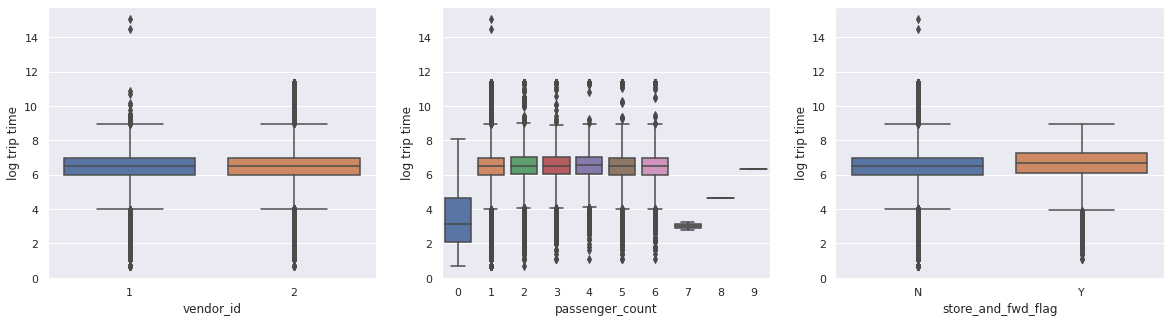

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for i, col in enumerate(unseen_cols):
    sns.boxplot(x=col, y='log_trip_duration', data=Train, whis=2, ax=axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('log trip time')

plt.show();

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Train = Train.assign(
    vendor_id = Train.vendor_id - 1,
    store_and_fwd_flag = Train.store_and_fwd_flag.map({'N': 0, 'Y' : 1})
)

Test = Test.assign(
    vendor_id = Test.vendor_id - 1,
    store_and_fwd_flag = Test.store_and_fwd_flag.map({'N': 0, 'Y' : 1})
)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
features = Train.columns.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_datetime', 'trip_duration','log_trip_duration', 'haversine'])
target = 'log_trip_duration'

numeric_cols = ['log_haversine', 'day_year']
categor_cols = ['passenger_count', 'weekday', 'month_year', 'hour_day', 'pickup_cell', 'dropoff_cell']

preprocessor_unseen_cols = ColumnTransformer(
    [
     ('numerical', StandardScaler(), numeric_cols),
     ('categorical', OneHotEncoder(handle_unknown="ignore"), categor_cols)
    ],
    remainder='passthrough'
)

work_pipe = make_pipeline(preprocessor_unseen_cols, Ridge())
model = work_pipe.fit(Train[features], Train[target])

y_pred = model.predict(Test[features])

print("MSE = %.8f" % mean_squared_error(Test[target], y_pred)) 

MSE = 0.23115145


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных: delta = 0.0003

In [ ]:
# Train.drop(columns=unseen_cols, inplace=True)
# Test.drop(columns=unseen_cols, inplace=True)
# drop later because needed

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

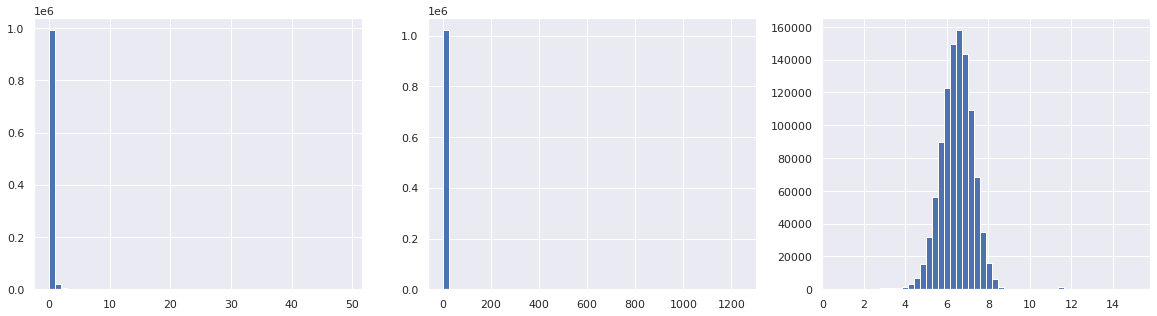

In [ ]:
residuals = (model.predict(Train[features]) - Train[target]) ** 2
anomaly_datas = (residuals.values, Train['haversine'].values, Train['log_trip_duration'].values)

fig, axs = plt.subplots(ncols=3, figsize=(20,5))
for ax, data in zip(axs, anomaly_datas):
    ax.hist(data, bins=50)
plt.show();
# Train.drop(columns=unseen_cols, inplace=True)
# Test.drop(columns=unseen_cols, inplace=True)

In [ ]:
resid_quant_99, havers_quant_99 = np.quantile(np.array(anomaly_datas[:-1]), q=0.98, axis=1)
mask_anomalies = (residuals > resid_quant_99) | (Train['haversine'] > havers_quant_99) | (Train['log_trip_duration'].between(left=np.exp(4), right=np.exp(9)))
Train.drop(Train[mask_anomalies].index, axis=0, inplace=True)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

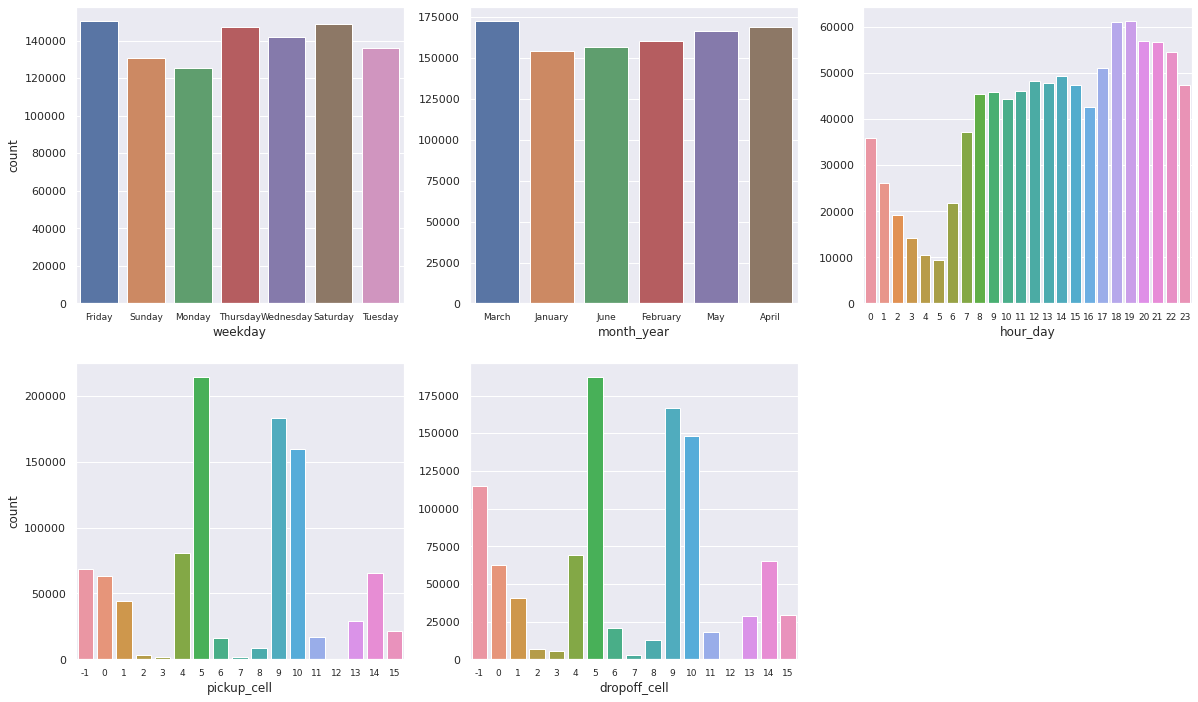

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categor_cols = ['weekday', 'month_year', 'hour_day', 'pickup_cell', 'dropoff_cell']
plt.figure(figsize=(20,12))
for i, col in enumerate(categor_cols):
    ax_i = plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=Train, ax=ax_i)
    ax_i.xaxis.set_tick_params(labelsize=9)
    if not(i % 3 == 0):
        ax_i.set(ylabel=None)
plt.show();

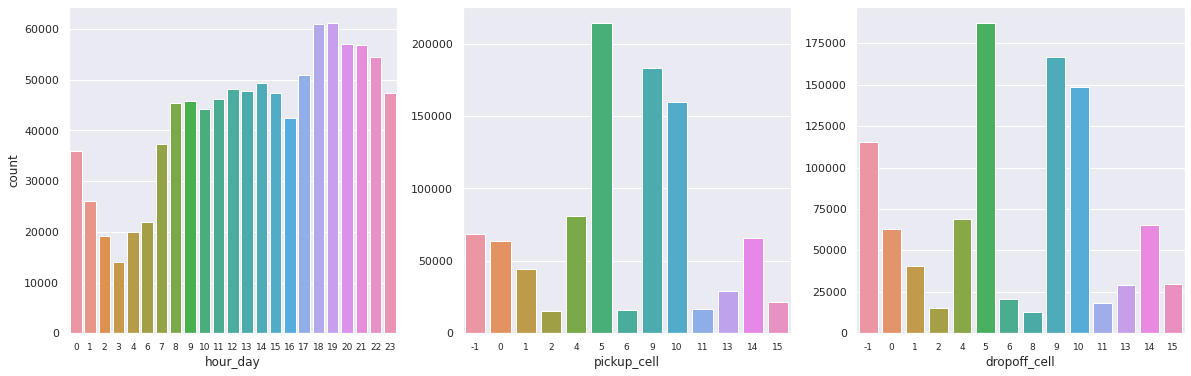

In [ ]:
Train.loc[Train['hour_day'].between(left=4, right=5), 'hour_day'] = 4
Train.loc[Train['pickup_cell'].isin(values=[2, 3, 7, 8, 12]), 'pickup_cell'] = 2
Train.loc[Train['dropoff_cell'].isin(values=[2, 3, 7, 12]), 'dropoff_cell'] = 2

changed_categ = ['hour_day', 'pickup_cell', 'dropoff_cell']
plt.figure(figsize=(20,6))
for i, col in enumerate(changed_categ):
    ax_i = plt.subplot(1, 3, i+1)
    sns.countplot(x=col, data=Train, ax=ax_i)
    ax_i.xaxis.set_tick_params(labelsize=9)
    if not(i == 0):
        ax_i.set(ylabel=None)
plt.show();

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [ ]:
features = Train.columns[11:].drop('haversine')
target = 'log_trip_duration'

# preprocessor - from ridge() with map_areas feature
ridge_pipe = make_pipeline(preprocessor, Ridge())
model_ridge = ridge_pipe.fit(Train[features], Train[target])

y_pred = model_ridge.predict(Test[features])
print(f"MSE Ridge: {mean_squared_error(Test[target], y_pred):.8f}")

MSE Ridge: 0.23271348


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print(f"Features before:{len(features)}\nFeatures after:{preprocessor.get_feature_names_out().size}")

Features before:11
Features after:69


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?


__Ответ__: Lasso(default_alpha=0) ~ LinearRegression. 
Необходим подбор гиперпараметра


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Lasso

# Lasso(default_alpha = 0) ~ LinearRegression
lasso_pipe = make_pipeline(preprocessor, Lasso()) # default step-name duplicates method, so 'lasso':Lasso()
model_lasso = lasso_pipe.fit(Train[features], Train[target])
y_pred = model_lasso.predict(Test[features])
print(f"MSE Lasso: {mean_squared_error(Test[target], y_pred):.8f}")

MSE Lasso: 0.63300803


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import ParameterGrid
# ParameterGrid используется, чтобы сформировать комбинации гиперпараметров модели
# в данном случае он избыточен, гиперпараметр всего один - по его значением можно было просто проитерироваться
# GridSearchCV - перебор гиперпараметров с кросс-валидацией, условие задания требует простое разбиение, а не кросс-валидацию 

from itertools import repeat, starmap

def hyperparam_choice(X_train, X_valid, grid, model):
    best_score = np.inf
    best_model, model_fitted = None, None
    for param in ParameterGrid(grid):
        model.set_params(**param)
        model_fitted = model.fit(X_train[features], X_train[target])
        score_tmp = mean_squared_error(X_valid[target], model_fitted.predict(X_valid[features]))
        # save if best
        if score_tmp < best_score:
            best_param = param
            best_score = score_tmp
    return best_param, best_score

Train_, Validat_ = train_test_split(Train, test_size=0.2, random_state=5)
# перебираем alpha по логарифмической сетке (lg), чтобы узнать оптимальный порядок (10^?) величины 
alphas = np.logspace(-3, 3, 7)
grids = ({"lasso__alpha" : alphas}, {"ridge__alpha" : alphas})
models = (model_lasso, model_ridge)
lasso_res, ridge_res = starmap(
    hyperparam_choice, 
    zip(
        repeat(Train_, 2), repeat(Validat_, 2),
        grids, models
    )
)

print(f"Hyperparameters:{lasso_res[0], ridge_res[0]}\nScores{lasso_res[1]:.4f}, {ridge_res[1]:.4f}")

Hyperparameters:({'lasso__alpha': 0.001}, {'ridge__alpha': 0.01})
Scores0.1438, 0.1421


In [ ]:
best_alpha = ridge_res[0]['ridge__alpha']
ridge_pipe_best = make_pipeline(preprocessor, Ridge(best_alpha))
model_ridge_best = ridge_pipe_best.fit(Train[features], Train[target])

y_pred = model_ridge_best.predict(Test[features])
print(f"MSE Ridge: {mean_squared_error(Test[target], y_pred):.8f}")

MSE Ridge: 0.23271334



Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.